***
# 0.2 Attaching spectrograms to segmentation
### JX, 03/07/2022
***

Parse JSON files representing segmentation data and attach spectrograms.
    
***

## Predefining hyperparameters for attaching spectrograms

In [1]:
## import necessary modules
from butcherbird.data.hparams import HParams

In [2]:
### Create a set of hyperparameters for processing this dataset.  
hparams = HParams(
    win_length_ms = 10, ##window len in ms
    hop_length_ms = 1, ##shuffle
    n_fft = 2048, ##number of frequency bands
    ref_level_db = 80, ## decibel scaling of spec
    min_level_db = -90, ## noise floor
    preemphasis = 0.97,
    num_mel_bins = 64, ##mel scaling: frequency scaling that matches cochlea (how compressed)
    mel_lower_edge_hertz = 500, ## 500 - 3000 for butcherbird
    mel_upper_edge_hertz = 3000, ##
    power = 1.5,  # for spectral inversion
    griffin_lim_iters = 50,
    butter_lowcut = 500, ##bandpass filter
    butter_highcut = 3000, ##bandpass filter (same as mel)
    reduce_noise = False,
    noise_reduce_kwargs = {},
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    nex = 100, ## grab as many as 100 json files
    n_jobs = -1, ## change from -1
    verbosity = 1,
)

## Create DataSet object from all JSON files

In [3]:
from butcherbird.data.dataset import DataSet

/home/AD/j8xing/syntax_rhythm_pbb/butcherbird/data/dataset.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
## Indicate DataSet Object Name
DATASET_ID = 'butcherbird'
dataset = DataSet(DATASET_ID, hparams = hparams)

loading json:   0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.6s finished


getting unique individuals:   0%|          | 0/7 [00:00<?, ?it/s]

2022-03-07 18:54:57.062629: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-07 18:54:57.062697: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: txori
2022-03-07 18:54:57.062711: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: txori
2022-03-07 18:54:57.062838: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-03-07 18:54:57.062882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-03-07 18:54:57.062894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1


## Check JSON

In [5]:
import json

In [6]:
# to make sure everything loaded correctly, lets look at a sample JSON
# json.dumps convert json into printable string
print(json.dumps(dataset.sample_json, indent=4, default=str)[:400] + '...')

{
    "species": "Cracticus nigrogularis",
    "common_name": "Pied butcherbird",
    "wav_loc": "/mnt/cube/j8xing/syntax_rhythm_pbb/data/interim/denoised/LS110143.10.12.2015GeoGreens_dn.wav",
    "wav_nm": "LS110143.10.12.2015GeoGreens_dn",
    "lengths_s": 158398490,
    "samplerate_hz": 44100,
    "indvs": {
        "Bird5": {
            "tg_loc": "/mnt/cube/j8xing/syntax_rhythm_pbb/data/inter...


## Create DataFrame to house dataset

In [7]:
from tqdm.autonotebook import tqdm ## import progress bar

from butcherbird.signalprocessing.create_spectrogram_note_dataset import (
    prepare_wav,
    create_label_df,
    get_row_audio,
) ## import necessary objects that create spectrograms

import pandas as pd
import numpy as np

In [8]:
from joblib import Parallel, delayed

## For n_jobs below -1, (n_cpus + 1 + n_jobs) are used.
## Verbosity: If it more than 10, all iterations are reported.
n_jobs = 36; verbosity = 10

In [9]:
## parallel pars dataset into dataframe
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    note_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="notes",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=36)]: Done   2 out of   7 | elapsed:    2.3s remaining:    5.7s
[Parallel(n_jobs=36)]: Done   3 out of   7 | elapsed:    2.3s remaining:    3.1s
[Parallel(n_jobs=36)]: Done   4 out of   7 | elapsed:    2.6s remaining:    1.9s
[Parallel(n_jobs=36)]: Done   5 out of   7 | elapsed:    2.6s remaining:    1.0s
[Parallel(n_jobs=36)]: Done   7 out of   7 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=36)]: Done   7 out of   7 | elapsed:    2.8s finished


In [10]:
note_df = pd.concat(note_dfs)
print(len(note_df), 'notes recorded into note_df')

31767 notes recorded into note_df


## For each note, grab the corresponding audio

In [11]:
note_df

,phrase_nb,phrase_strt,phrase_end,phrase_len,note_cnt,note_nb,note_strt,note_end,note_len,indv,indvi,key
0,0,513.780000,517.061923,3.281923,15,0,513.780000,513.905214,0.125214,Bird5,0,LS110143.10.12.2015GeoGreens_dn
1,0,513.780000,517.061923,3.281923,15,1,513.917747,513.980936,0.063188,Bird5,0,LS110143.10.12.2015GeoGreens_dn
2,0,513.780000,517.061923,3.281923,15,2,514.170000,514.480698,0.310698,Bird5,0,LS110143.10.12.2015GeoGreens_dn
3,0,513.780000,517.061923,3.281923,15,3,514.620783,515.310000,0.689217,Bird5,0,LS110143.10.12.2015GeoGreens_dn
4,0,513.780000,517.061923,3.281923,15,4,515.355217,515.660180,0.304964,Bird5,0,LS110143.10.12.2015GeoGreens_dn
...,...,...,...,...,...,...,...,...,...,...,...,...
3374,372,3653.360023,3654.258666,0.898643,9,4,3653.853352,3653.888139,0.034787,Bird5,0,LS110136.10.10.2015GeoGreens_dn
3375,372,3653.360023,3654.258666,0.898643,9,5,3653.891925,3653.948207,0.056282,Bird5,0,LS110136.10.10.2015GeoGreens_dn
3376,372,3653.360023,3654.258666,0.898643,9,6,3654.008784,3654.031501,0.022716,Bird5,0,LS110136.10.10.2015GeoGreens_dn
3377,372,3653.360023,3654.258666,0.898643,9,7,3654.039073,3654.148869,0.109796,Bird5,0,LS110136.10.10.2015GeoGreens_dn


In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    note_dfs = parallel(
        delayed(get_row_audio)(
            note_df[note_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(note_df.key.unique())
    )
note_df = pd.concat(note_dfs)
len(note_df)

  0%|          | 0/7 [00:00<?, ?it/s]

[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=36)]: Done   2 out of   7 | elapsed:   12.1s remaining:   30.3s
[Parallel(n_jobs=36)]: Done   3 out of   7 | elapsed:   12.4s remaining:   16.5s
[Parallel(n_jobs=36)]: Done   4 out of   7 | elapsed:   12.7s remaining:    9.5s
[Parallel(n_jobs=36)]: Done   5 out of   7 | elapsed:   13.1s remaining:    5.2s
[Parallel(n_jobs=36)]: Done   7 out of   7 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=36)]: Done   7 out of   7 | elapsed:   20.4s finished


31767

In [13]:
# this is just getting rid of notes that are zero seconds long, which be the product of errors in segmentation
df_mask  = np.array([len(i) > 0 for i in tqdm(note_df.audio.values)])
note_df = note_df[np.array(df_mask)]

  0%|          | 0/31767 [00:00<?, ?it/s]

## Signal Processing

### Normalize

In [14]:
import librosa

In [15]:
note_df['audio'] = [librosa.util.normalize(i) for i in tqdm(note_df.audio.values)]

  0%|          | 0/31767 [00:00<?, ?it/s]

### Taper

In [16]:
from butcherbird.signalprocessing.audio import taper_signal

In [17]:
sylls = note_df.audio.values

In [18]:
## Linearly ramp 150 samples on both ends
note_df['audio'] = [taper_signal(syll, 150) for syll in tqdm(sylls)]

  0%|          | 0/31767 [00:00<?, ?it/s]

### Plot Audio to verify

In [19]:
import matplotlib.pyplot as plt

  0%|          | 0/50 [00:00<?, ?it/s]

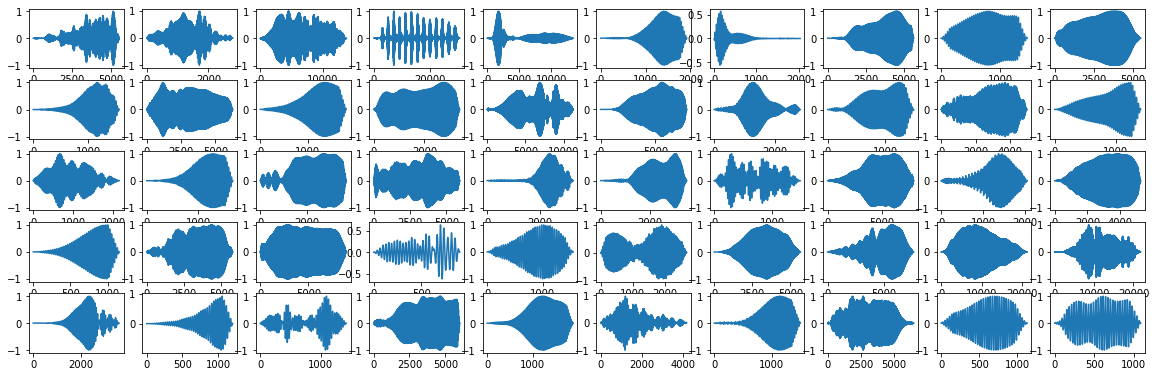

In [20]:
# plot some example audio 
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(note_df['audio'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

## Create spectrogram for each note

In [21]:
from butcherbird.signalprocessing.create_spectrogram_note_dataset import make_spec

In [22]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    notes_spec = parallel(
        delayed(make_spec)(
            note,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for note, rate in tqdm(
            zip(note_df.audio.values, note_df.rate.values),
            total=len(note_df),
            desc="getting note spectrograms",
            leave=False,
        )
    )

getting note spectrograms:   0%|          | 0/31767 [00:00<?, ?it/s]

[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1479
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1158
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=903
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1545
  return f(*args, **kwargs)
[Parallel(n_jobs=36)]: Batch computation too fast (0.0363s.) Setting batch_size=2.
[Parallel(n_jobs=36)]: Done  13 tasks      | elapsed:    0.1s
/home/AD/j8

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1503
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1586
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2047
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1461
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1670
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2004
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1002
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1420
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1737
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1920
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1597
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1923
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1645
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1058
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1640
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1333
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1562
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1268
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1484
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1586
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1705
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=831
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1649
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1837
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1566
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1419
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1669
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1335
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1837
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2004
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1252
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=831
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1670
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1079
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1420
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1002
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1628
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2003
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1419
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1586
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1753
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1629
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1098
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1489
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1920
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1336
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=835
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1257
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1169
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1920
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1944
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1419
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1169
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1503
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=984
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2002
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1836
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1585
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1585
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1743
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1846
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1847
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1751
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1377
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1798
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1548
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1587
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=876
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1335
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1702
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1857
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1664
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1470
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1780
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1664
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1429
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1728
  return f(*args, **kwargs)
[Parallel(n_jobs=36)]: Done 4600 tasks      | elapsed:    5.1s
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1627
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2003
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1630
  ret

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2012
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1461
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1242
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=835
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1336
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1577
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1895
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1503
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1670
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1880
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1205
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1577
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1786
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1808
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2003
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1590
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1626
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1599
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1642
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1374
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1255
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1286
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1235
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1859
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1984
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1393
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1069
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1942
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2026
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1538
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=378
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1575
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1745
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1847
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=852
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/pyt

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1909
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1589
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1600
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1679
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1837
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1865
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1576
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1169
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1822
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1652
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1481
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1747
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1625
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1309
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1829
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1584
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1278
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1472
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1489
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1625
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1610
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1463
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1200
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1634
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1741
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1318
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=954
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1493
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1782
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1316
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1538
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1658
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1791
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1782
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=887
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1432
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1516
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1432
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2022
  return f(*args, **kwargs)
[Parallel(n_jobs=36)]: Done 9864 tasks      | elapsed:    8.9s
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1390
  ret

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1854
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1516
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1516
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1685
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1938
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=927
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1516
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1600
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2022
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1263
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1786
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1424
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1585
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1955
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1752
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1335
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1175
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1669
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1502
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1635
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2002
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1974
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1629
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1836
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1767
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1690
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1836
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1602
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1418
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1857
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1393
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1915
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1327
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1316
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1394
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1935
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1641
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1626
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1809
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1935
  return f(*args, **kwargs)
[Parallel(n_jobs=36)]: Done 13576 tasks 

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1936
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1819
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1470
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1394
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1161
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2023
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1787
  return f(*args, **kwargs)
[Parallel(n_jobs=36)]: Done 14584 tasks      | elapsed:   12.4s
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1081
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1627
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1418
  re

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1877
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1919
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1377
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1209
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1159
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1710
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1751
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1711
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1460
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1790
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1633
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2002
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1912
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1668
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1294
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1290
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1439
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1585
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=897
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1864
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1576
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1449
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=876
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1429
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1864
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1755
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2030
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1883
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2035
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=956
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1786
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=647
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1907
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1429
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1815
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=966
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1166
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1707
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1732
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1046
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=880
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1943
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1540
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1815
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1451
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1973
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1870
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1650
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1632
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1552
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1162
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1512
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1739
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1299
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1760
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1489
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1829
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1861
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=995
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1362
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1785
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1998
  return f(*args, **kwargs)
[Parallel(n_jobs=36)]: Done 20104 tasks      | elapsed:   16.3s
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1087
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1907
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1453
  re

[Parallel(n_jobs=36)]: Done 20704 tasks      | elapsed:   16.7s
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1998
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1389
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1816
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1462
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1634
  re

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1680
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=975
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2026
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1680
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1392
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2041
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1663
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1437
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1280
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1826
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=867
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1884
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1521
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1725
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1544
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1920
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1832
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1435
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1212
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1065
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1226
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1938
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1779
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1902
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1854
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1706
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1601
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1558
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=885
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1685
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

[Parallel(n_jobs=36)]: Done 24448 tasks      | elapsed:   19.5s
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1727
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=663
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1887
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=861
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2031
  retu

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1499
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1979
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1727
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1422
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1538
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1559
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1853
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1495
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1769
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1601
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=800
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=927
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1080
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=921
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1811
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/pyth

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1601
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1517
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1317
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1533
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1982
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1757
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1791
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1829
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1622
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1369
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1679
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1997
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1816
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1816
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1090
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1039
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1188
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=829
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1541
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1879
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1007
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2014
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1565
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1437
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1566
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1691
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1135
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1822
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1326
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1988
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1670
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1169
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1995
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1158
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1409
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1411
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1784
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1165
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1821
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1186
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1565
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1762
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1351
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1127
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2027
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/p

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1502
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=668
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1836
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=986
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1604
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/pyt

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1221
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1168
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1158
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=924
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=2003
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=662
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1384
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1659
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1295
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1371
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=476
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1834
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1909
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1377
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1341
  return f(*args, **kwargs)
/home/AD/j8xing/anaconda3/envs/pbb/lib/py

In [23]:
# (optional) normalize the spectrograms into uint8, to make the dataset smaller
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
notes_spec = [(norm(i)*255).astype('uint8') for i in tqdm(notes_spec)]

  0%|          | 0/31767 [00:00<?, ?it/s]

## Visually Inspect Spectrograms

In [24]:
from butcherbird.visualization.spectrogram import draw_spec_set

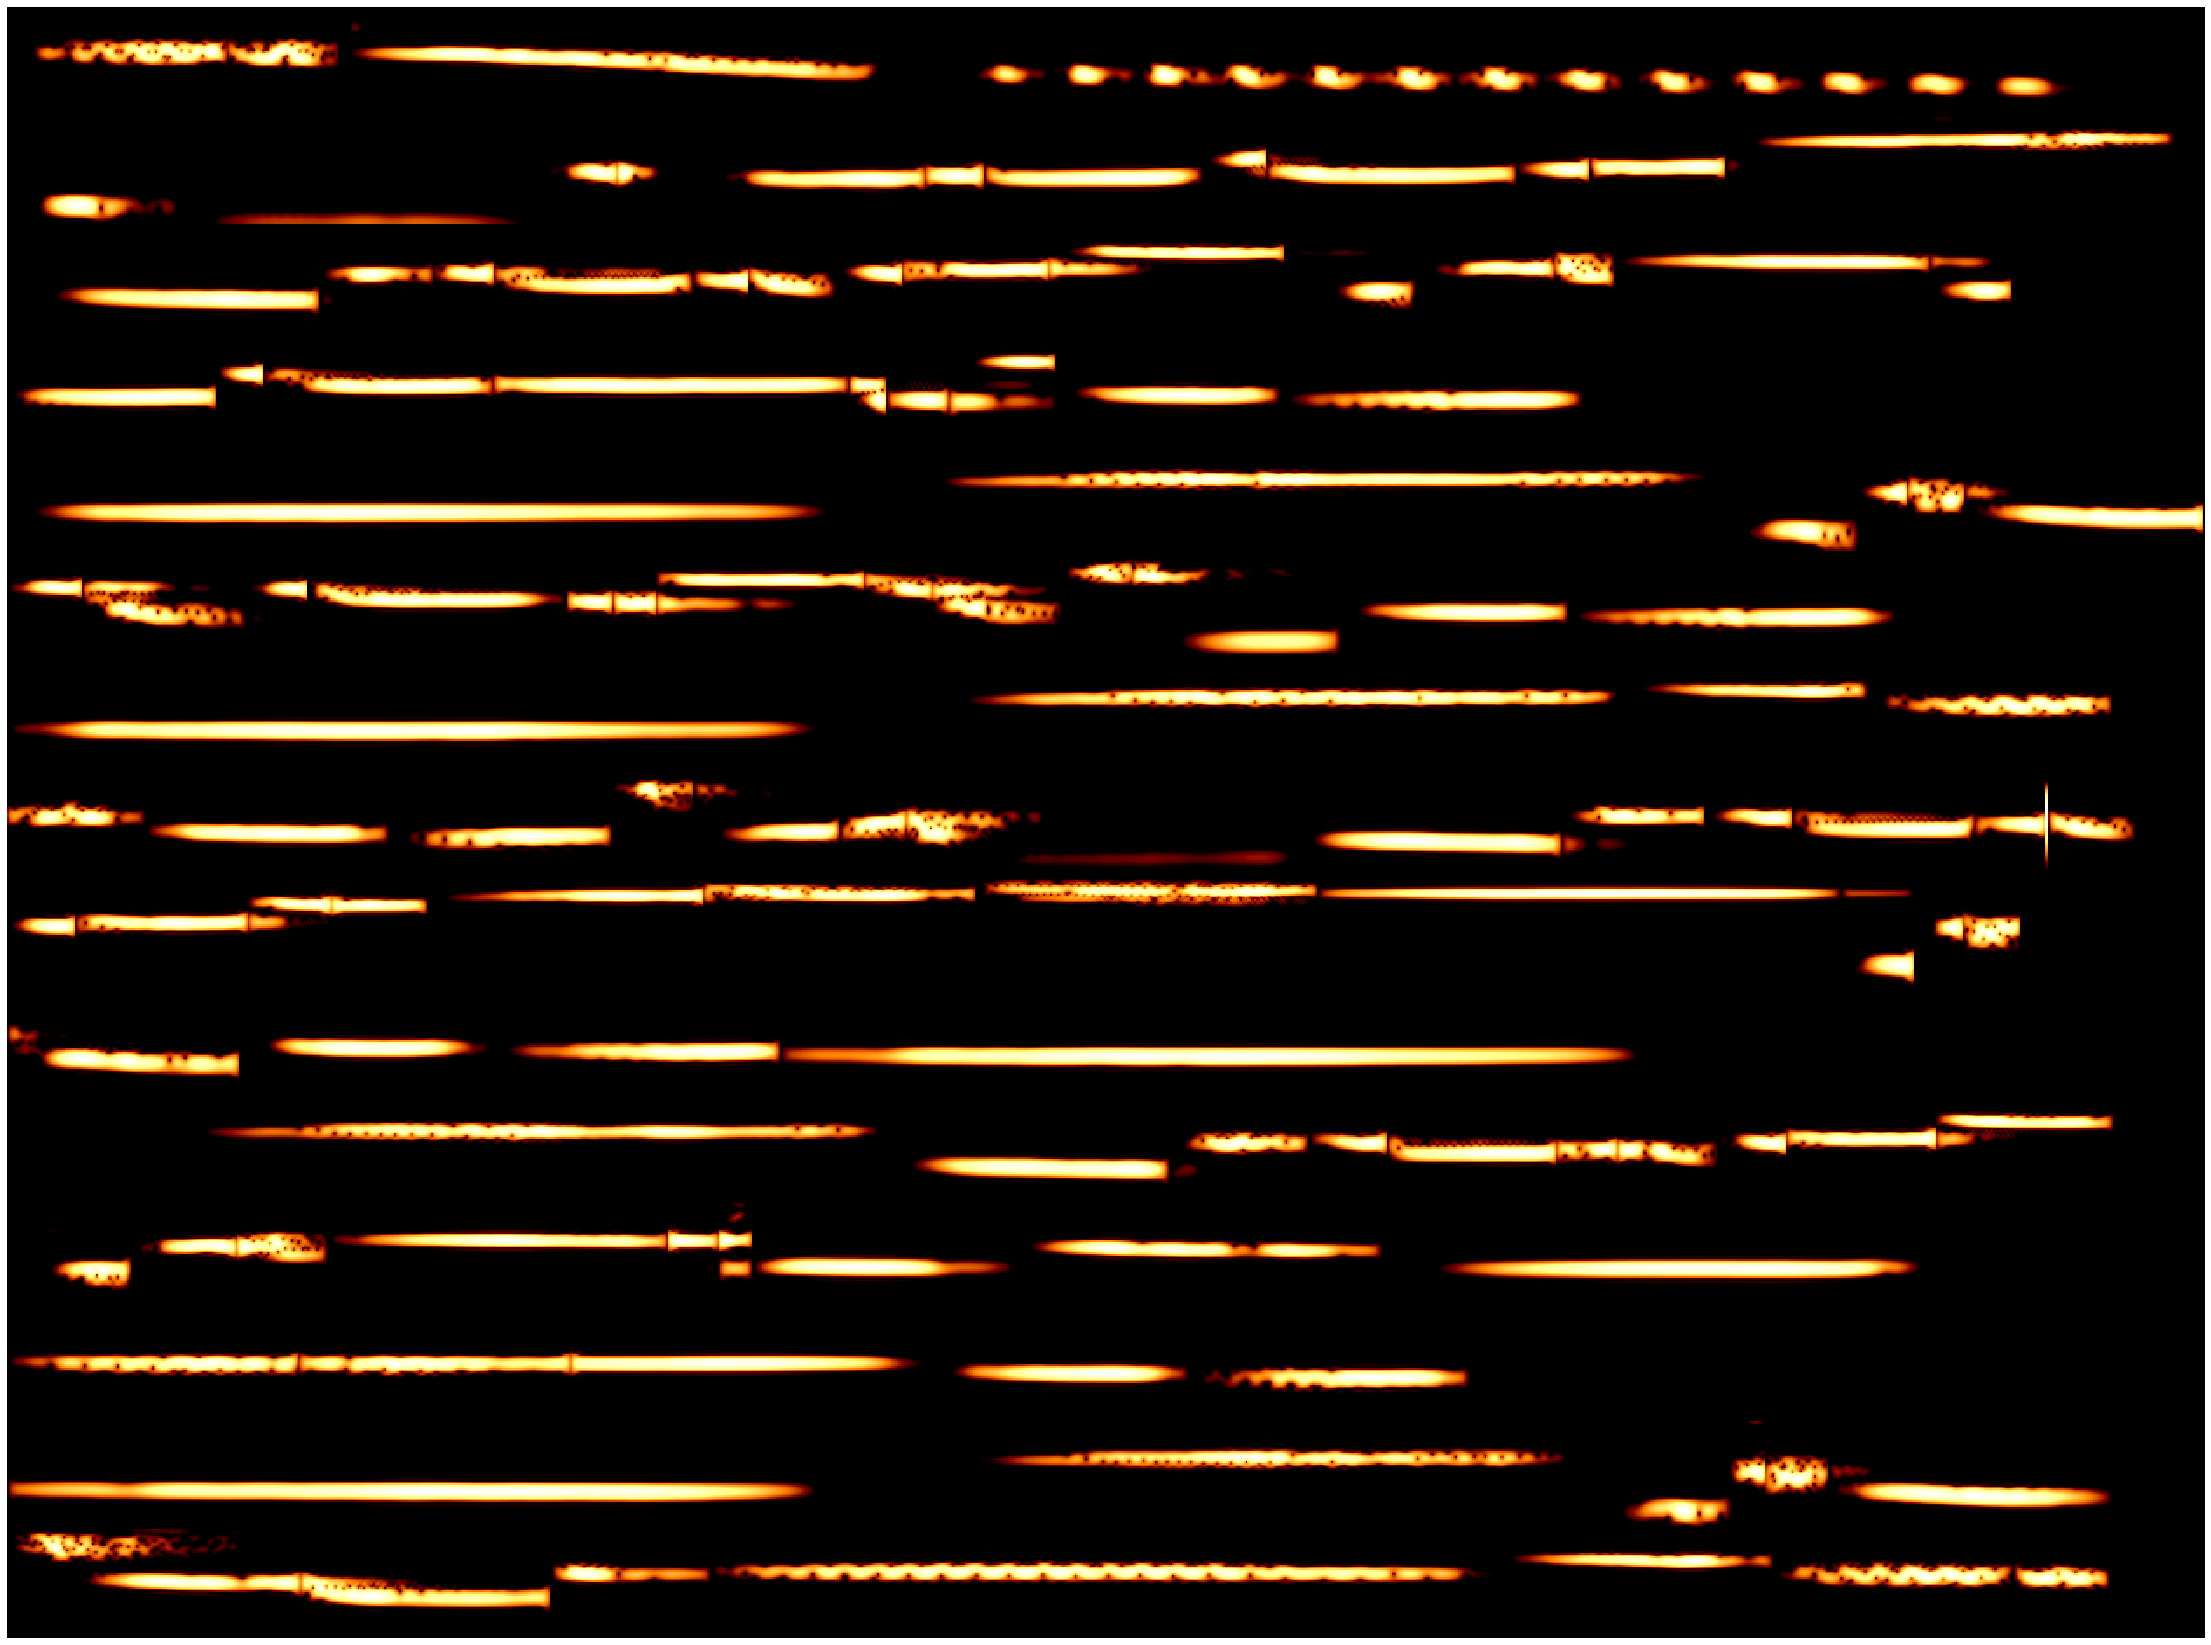

In [25]:
draw_spec_set(notes_spec, zoom = 2, maxrows = 15, colsize = 10)

## Append Spectrograms to note_df

In [26]:
note_df['spectrogram'] = notes_spec

## Save

In [27]:
from butcherbird.utils.paths import DATA_DIR, ensure_dir
import pathlib2

In [28]:
save_loc = DATA_DIR / 'interim/raw_spectrogram/butcherbird_note_df.pickle'

In [29]:
ensure_dir(save_loc)

In [30]:
note_df.to_pickle(save_loc)